more exploration of NBA line data, focusing on over/under bets, but a little money stuff first.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [1]:
import scrape_yahoo_nba

In [2]:
scraper = scrape_yahoo_nba.ScrapeYahooNBA()

df = scraper.load_summary_csv()


In [3]:
df.iloc[11]

Unnamed: 0                                     0
game_date                       2021-10-20-10:00
away_team                              Cleveland
home_team                                Memphis
pregame_odds                       -7, O/U 217.5
total_over_points                          218.5
total_over_stake_percentage                66.93
total_over_wager_percentage                67.78
total_over_odds                             -110
total_over_decimal_odds                     1.91
total_over_won                              True
total_under_points                         218.5
total_under_stake_percentage               33.07
total_under_wager_percentage               32.22
total_under_odds                            -110
total_under_decimal_odds                    1.91
total_under_won                            False
money_away_odds                              240
money_away_decimal_odds                      3.4
money_away_stake_percentage                12.04
money_away_wager_per

## What side does the public take on money bets?

got to drop any games that don't have money info

In [4]:
# completed_game = ~df.spread_home_won.isna() # the game was completed, so there is a winner
# has_spread_stake_percentage = ~df.spread_home_stake_percentage.isna()

# df_has_spread = df.loc[completed_game & has_spread_stake_percentage].copy()


df = df.loc[~df.money_home_wager_percentage.isna()].copy()

In [5]:
import money_data

df = money_data.add_money_columns(df)

the public takes the home team on the money lines 64% of the time

In [6]:
df.money_popular.value_counts() /len(df)

money_popular
HOME    0.636702
AWAY    0.363298
Name: count, dtype: float64

the popular side of the money line wins 68% of the time. that could be good or bad depending on the odds taken.

In [7]:
df.money_popular_won.value_counts() / len(df)

money_popular_won
True     0.677619
False    0.322381
Name: count, dtype: float64

how about the favorite versus the underdog?

The public almost always backs the favorite on the money line. I was really surprised by this

In [8]:
df.money_fave_dog.value_counts()

money_fave_dog
FAVE    4656
DOG      183
Name: count, dtype: int64

In [ ]:
4656 + 183

4839

In [ ]:
4656 / 4839

0.9621822690638562

In [11]:
popular_odds = pd.concat([df[df.money_popular=='HOME'].money_home_odds, df[df.money_popular=='AWAY'].money_away_odds])

In [12]:
sum(popular_odds < 0)

4656

american odds are weird in that there are no values between -100 and 0, ,and between 0 and 100. so summary statistics are going to be wacky

In [ ]:
popular_odds.describe()

count     4839.000000
mean      -339.458153
std        407.657205
min     -10000.000000
25%       -375.000000
50%       -225.000000
75%       -155.000000
max        400.000000
dtype: float64

In [ ]:
popular_odds.median()

np.float64(-225.0)

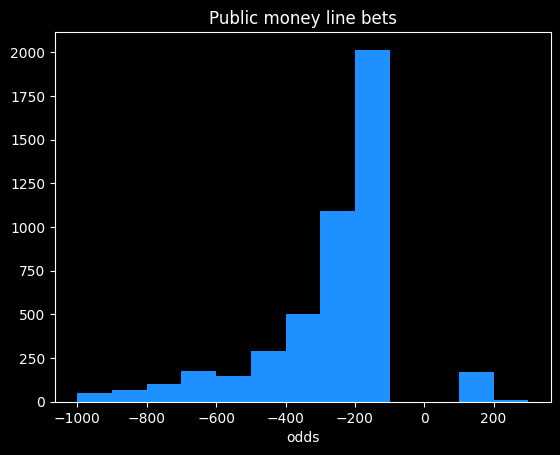

In [ ]:
_out = plt.hist(popular_odds, color='dodgerblue', bins=range(-1000, 400, 100))
_out = plt.title("Public money line bets")
_out = plt.xlabel("odds")

### so did the public win money or lose money? could you have made money fading the public on money line bets?

money line bets are a pain in the butt because of how the odds are written. hard to do in idiomatic pandas.

In [13]:
profit_loss = 0
num_games = 0

def calc_payout(money_line):
    if money_line < 0:
        return 100 * (100/np.abs(money_line))
    else:
        return money_line


for idx, game in df.iterrows():
    if game.money_popular == 'HOME':
        if game.money_home_won:
            profit_loss += calc_payout(game.money_home_odds)
        else:
            profit_loss -= 100
    if game.money_popular == 'AWAY':
        if game.money_away_won:
            profit_loss += calc_payout(game.money_away_odds)
        else:
            profit_loss -= 100

print(profit_loss/ len(df))

-2.8673637321944216


In [14]:
calc_payout(-200)

np.float64(50.0)

fading the public would give around a -6.4% rate of return, versus -2.87% for following the public

In [15]:
profit_loss = 0

for idx, game in df.iterrows():
    if game.money_popular == 'HOME': # backwards; we're fading the public
        if game.money_home_won:
            profit_loss += calc_payout(game.money_home_odds)
        else:
            profit_loss -= 100
    if game.money_popular == 'AWAY':
        if game.money_away_won:
            profit_loss += calc_payout(game.money_away_odds)
        else:
            profit_loss -= 100

print(profit_loss/len(df))


-2.8673637321944216


how did the public do on their underdog bets

In [16]:
popular_dogs = df[df.money_fave_dog == 'DOG'].copy()

the public went 86-97 on their dog picks, which could be good depending on the dods

In [17]:
popular_dogs.money_popular_won.value_counts()

money_popular_won
False    97
True     86
Name: count, dtype: int64

In [ ]:
popular_dogs.iloc[1]

Unnamed: 0                                     0
game_date                       2021-10-22-10:00
away_team                                Indiana
home_team                             Washington
pregame_odds                         -2, O/U 226
total_over_points                          226.0
total_over_stake_percentage                71.79
total_over_wager_percentage                63.85
total_over_odds                             -110
total_over_decimal_odds                     1.91
total_over_won                              True
total_under_points                         226.0
total_under_stake_percentage               28.21
total_under_wager_percentage               36.15
total_under_odds                            -110
total_under_decimal_odds                    1.91
total_under_won                            False
money_away_odds                             -140
money_away_decimal_odds                     1.72
money_away_stake_percentage                38.06
money_away_wager_per

In [ ]:
df.money_home_won.value_counts() / len(df)

money_home_won
True     0.55404
False    0.44596
Name: count, dtype: float64

the public actually had a positive rate of return on the underdog bets they took!

In [ ]:
len(popular_dogs)

183

In [ ]:
profit_loss = 0
for idx, game in popular_dogs.iterrows():
    if game.money_popular == 'HOME':
        if game.money_home_won:
            profit_loss += calc_payout(game.money_home_odds)
        else:
            profit_loss -= 100
    if game.money_popular == 'AWAY':
        if game.money_away_won:
            profit_loss += calc_payout(game.money_away_odds)
        else:
            profit_loss -= 100

print(profit_loss / len(popular_dogs))

2.431693989071038


is there a correlation between betting one side on the spread, and one side on the money? Indeed there is. (since home wager percentage + away wager percentage = 0, we can just look at the home percentages)

In [ ]:
df.money_home_wager_percentage.corr(df.spread_home_wager_percentage)

np.float64(0.29479608916154043)

# OVER/UNDer STUFF


In [18]:
df.total_over_won.value_counts()

total_over_won
True     2461
False    2378
Name: count, dtype: int64

In [ ]:
(2672 + 2601)

5273

In [ ]:
2672 / 5273

0.5067324103925659

people overwhelmingly prefer betting the over

In [19]:
df.total_over_wager_percentage.describe()

count    4836.000000
mean       78.778414
std        12.716867
min        15.350000
25%        72.427500
50%        81.870000
75%        88.160000
max        98.790000
Name: total_over_wager_percentage, dtype: float64

In [20]:
df.total_over_odds.value_counts().iloc[:10]

total_over_odds
-110    3272
-115     909
-105     573
-300      23
-250       8
-120       8
-275       7
 100       6
-190       5
-225       4
Name: count, dtype: int64

there are a fair number of bets where the vig isn't -110. I will have to get back to this.

### Which teams have the highest and lowest average point totals?


In [21]:
mean_point_totals = .5 * (df.groupby('home_team').total_over_points.mean() + df.groupby('away_team').total_over_points.mean())

In [22]:
mean_point_totals.sort_values()

home_team
Miami            216.918535
Orlando          218.070649
New York         220.107353
Cleveland        220.980998
Philadelphia     221.329672
LA Clippers      221.881061
Boston           221.952443
Brooklyn         222.830877
Toronto          223.545060
Detroit          223.553928
Minnesota        223.764071
Dallas           223.984551
Portland         224.635972
New Orleans      225.215190
Oklahoma City    225.483787
Houston          225.592429
Charlotte        225.635545
Denver           225.964397
Phoenix          226.009771
Golden State     226.385768
Washington       226.726821
Milwaukee        226.728278
Chicago          226.763570
LA Lakers        227.843233
Utah             228.049737
Memphis          228.105983
San Antonio      229.011690
Indiana          230.107042
Sacramento       230.688743
Atlanta          231.092436
Name: total_over_points, dtype: float64

### How do the public do on over/under bets?

In [23]:
### need to drop rows where we don't have over/under data

df = df[df.total_over_won | df.total_under_won].copy()

In [24]:
len(df)

4839

In [25]:
df['total_popular'] = None
df.loc[df.total_over_wager_percentage > 50, 'total_popular'] = 'OVER'
df.loc[df.total_over_wager_percentage <= 50, 'total_popular'] = 'UNDER'


In [26]:
df.total_popular.value_counts()

total_popular
OVER     4658
UNDER     178
Name: count, dtype: int64

In [ ]:
len(df)

4839

woah, was not expecting such a huge bias towards overs

In [ ]:
sum(df.total_over_wager_percentage > 50) / len(df)

0.9625955775986774

the public won 51% of their bets on the over, and 54.5% of their bets on the under

In [ ]:
sum((df.total_popular == "OVER") & (df.total_over_won)) / sum(df.total_popular == "OVER")

0.5105195362816659

In [ ]:
sum((df.total_popular == "UNDER") & (df.total_under_won)) / sum(df.total_popular == "UNDER")

0.5449438202247191

###  Is it rational?

Is it rational behavior to take the over 88% of the time, when the over only wins slightly more often than the under?

It depends on whether you think you can actually see the future or not.

## is a higher wager level correlated with higher winning percentage?

In [ ]:
df.total_over_wager_percentage.describe()

count    4836.000000
mean       78.778414
std        12.716867
min        15.350000
25%        72.427500
50%        81.870000
75%        88.160000
max        98.790000
Name: total_over_wager_percentage, dtype: float64

looking at only bets on overs...

In [ ]:
public_overs = df[df.total_over_wager_percentage > 50]#.copy().sort_values(by='total_over_wager_percentage', ascending=True)

In [ ]:
len(public_overs) * .25

1164.5

there is probably a less tedious, copy-pastey way of doing this.

looking at win %age by quartile among the over bets. is bet percentage corr with win percentage?

In [ ]:
first_q  = public_overs[public_overs.total_over_wager_percentage < public_overs.total_over_wager_percentage.quantile(.25)]

In [ ]:
first_q.total_over_won.value_counts()

total_over_won
True     587
False    576
Name: count, dtype: int64

In [ ]:
588/(588+577)

0.5047210300429185

In [ ]:
588+577

1165

In [ ]:
public_overs.total_over_wager_percentage.quantile(.25)

np.float64(73.87)

In [ ]:
second_q  = public_overs[(public_overs.total_over_wager_percentage >= public_overs.total_over_wager_percentage.quantile(.25)) &
                         (public_overs.total_over_wager_percentage < public_overs.total_over_wager_percentage.quantile(.5))]

In [ ]:
second_q.total_over_won.value_counts()

total_over_won
True     598
False    566
Name: count, dtype: int64

In [ ]:
598/(598+566)

0.5137457044673539

In [ ]:
598 + 566

1164

In [ ]:
public_overs.total_over_wager_percentage.quantile(.5)

np.float64(82.38)

In [ ]:
third_q  = public_overs[(public_overs.total_over_wager_percentage >= public_overs.total_over_wager_percentage.quantile(.5)) &
                         (public_overs.total_over_wager_percentage < public_overs.total_over_wager_percentage.quantile(.75))]

third_q.total_over_won.value_counts()

total_over_won
True     592
False    571
Name: count, dtype: int64

In [ ]:
592/(592+571)

0.5090283748925194

In [ ]:
592 + 571

1163

In [ ]:
fourth_q  = public_overs[(public_overs.total_over_wager_percentage >= public_overs.total_over_wager_percentage.quantile(.75))]

fourth_q.total_over_won.value_counts()

total_over_won
True     601
False    567
Name: count, dtype: int64

In [ ]:
601 / (601+567)

0.514554794520548

In [ ]:
public_overs.total_over_wager_percentage.quantile(.75)

np.float64(88.4)

In [ ]:
601 + 567

1168

confidence intervals for these estimates. naive would be +/- 3% using normal approximation

In [ ]:
import statsmodels.stats.proportion

I believe the Wilson method is considered the most correct way to do a CI here

https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Comparison_and_discussion

In [ ]:
statsmodels.stats.proportion.proportion_confint(601, 1168, method='wilson')

(0.48589165771359394, 0.5431225060575162)

but using the traditional method (binomial approximation) gives almost exactly the same value.

this is one of those times I don't think statisticians do sig figs right. the denominator of the proportion is 1168, so shouldn't the width of the confidence interval be rounded to the nearest 1/1168 because the numerator will always be an integer? part of the problem with the usual normal approximation is it's treating a discrete thing (a ratio of two integers) and treating it like a continuous thing (the normal distribution). is the wilson method making a similar mistake? I don't know anything about it. something for another time, perhaps.

In [ ]:
statsmodels.stats.proportion.proportion_confint(601, 1168)

(0.4858923918958874, 0.5432171971452086)

## is there a correlation between point totals and over wager percentage?

are the public disinclined towards taking overs with big point totals?

let's look at general trends in the size of point totals.

In [27]:
df.total_over_points.describe()

count    4839.000000
mean      224.916718
std         9.386844
min       195.500000
25%       218.500000
50%       224.500000
75%       231.500000
max       257.500000
Name: total_over_points, dtype: float64

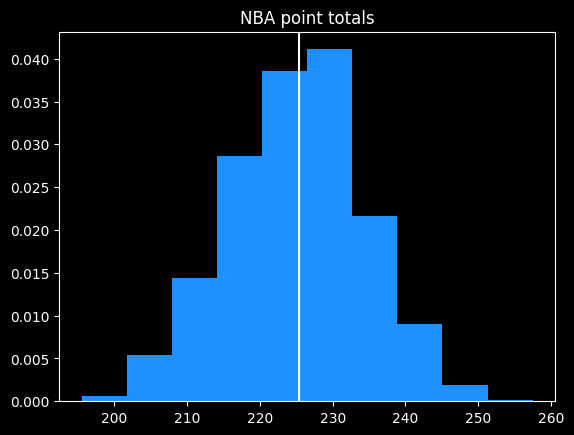

In [ ]:
_out = plt.hist(df.total_over_points, color='dodgerblue', density=True)
_out = plt.title("NBA point totals")
_out = plt.axvline(225.32, color='white')

there is a negative correlation between the point total and the number of bets on the over

In [28]:
df.total_over_wager_percentage.corr(df.total_over_points)

np.float64(-0.37356815701396723)

gamblers tend to take unders when the point total is higher than the mean

In [ ]:
df[df.total_over_wager_percentage < 50].total_over_points.mean()

np.float64(234.28932584269663)

and overs when the point total is a little below the mean

In [ ]:
df[df.total_over_wager_percentage >= 50].total_over_points.mean()

np.float64(224.5573207385144)

In [ ]:
df.iloc[10]

Unnamed: 0                                     0
game_date                       2021-10-20-10:00
away_team                             Washington
home_team                                Toronto
pregame_odds                     -2.5, O/U 223.5
total_over_points                          223.5
total_over_stake_percentage                78.63
total_over_wager_percentage                75.33
total_over_odds                             -110
total_over_decimal_odds                     1.91
total_over_won                             False
total_under_points                         223.5
total_under_stake_percentage               21.37
total_under_wager_percentage               24.67
total_under_odds                            -110
total_under_decimal_odds                    1.91
total_under_won                             True
money_away_odds                              115
money_away_decimal_odds                     2.15
money_away_stake_percentage                16.37
money_away_wager_per

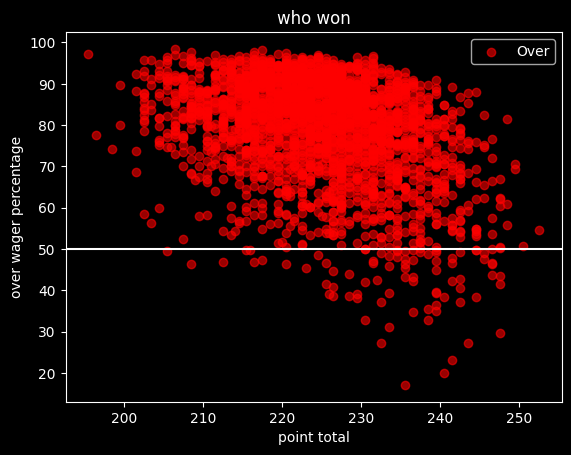

In [ ]:
over_won = df[df.total_over_won]
over_lost = df[~df.total_over_won].sample(1000)

plt.scatter(over_won.total_over_points, over_won.total_over_wager_percentage, label="Over", color='red', alpha=.6)
#plt.scatter(over_lost.total_over_points, over_lost.total_over_wager_percentage, label="Under", color='yellow', alpha=.6)


#plt.scatter(df.total_over_points, df.total_over_wager_percentage, c=df.total_over_won, cmap='autumn', label=df.total_over_won, alpha=.6)
_out = plt.legend()
_out = plt.axhline(50, color='white')
_out = plt.xlabel("point total")
_out = plt.ylabel("over wager percentage")
_out = plt.title("who won")



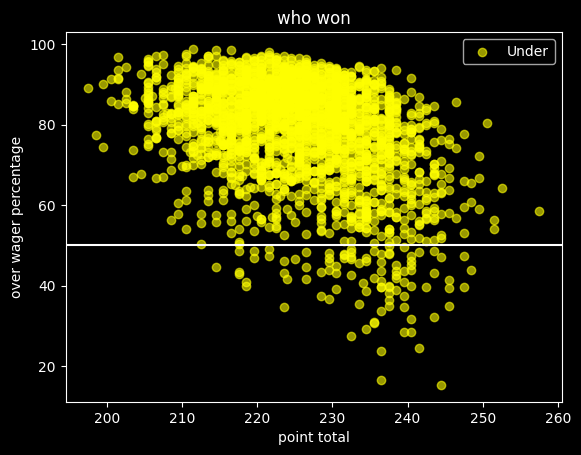

In [ ]:
over_won = df[df.total_over_won]
over_lost = df[~df.total_over_won]

plt.scatter(over_lost.total_over_points, over_lost.total_over_wager_percentage, label="Under", color='yellow', alpha=.6)


#plt.scatter(df.total_over_points, df.total_over_wager_percentage, c=df.total_over_won, cmap='autumn', label=df.total_over_won, alpha=.6)
_out = plt.legend()
_out = plt.axhline(50, color='white')
_out = plt.xlabel("point total")
_out = plt.ylabel("over wager percentage")
_out = plt.title("who won")

In [ ]:
over_won.total_over_points.describe()

count    2461.000000
mean      224.719829
std         9.379143
min       195.500000
25%       218.500000
50%       224.500000
75%       231.500000
max       252.500000
Name: total_over_points, dtype: float64

In [ ]:
over_lost.total_over_points.describe()

count    2378.000000
mean      225.120479
std         9.392434
min       197.500000
25%       218.500000
50%       225.500000
75%       231.500000
max       257.500000
Name: total_over_points, dtype: float64

### is there a correlation between point total and total over won percentage? are overs with a high point total a bad idea? are overs with a low point total a good idea?

In [ ]:
for x in range(0,100,10):
    band =   df[(df.total_over_wager_percentage >= x) & (df.total_over_wager_percentage < (x+10))]
    if len(band) > 0:
        if x < 50:
            num_won = sum(band.total_under_won)
        else:
            num_won = sum(band.total_over_won) 
        print(f"{x} to {x+10} -- { num_won / len(band)} on {len(band)} bets")

10 to 20 -- 0.6666666666666666 on 3 bets
20 to 30 -- 0.5454545454545454 on 11 bets
30 to 40 -- 0.5777777777777777 on 45 bets
40 to 50 -- 0.5294117647058824 on 119 bets
50 to 60 -- 0.5215827338129496 on 278 bets
60 to 70 -- 0.5090579710144928 on 552 bets
70 to 80 -- 0.5058611361587015 on 1109 bets
80 to 90 -- 0.5091496232508074 on 1858 bets
90 to 100 -- 0.5168408826945412 on 861 bets


have point totals gone up over 4 years?

I think playoff games are going to have lower point totals.

not a very decipherable graph. better to do it year over year

In [ ]:
moving_avg = pd.Series(df.total_over_points).rolling(window=200).mean().reset_index(drop=True)

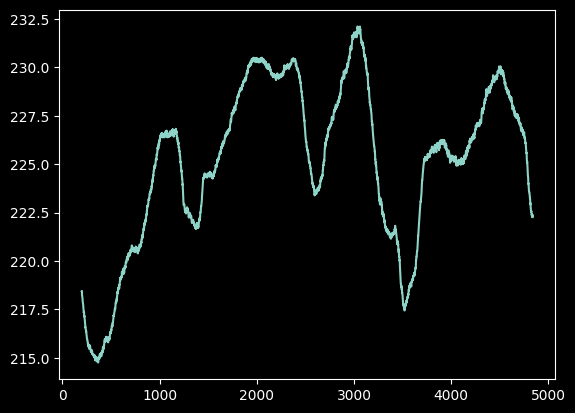

In [ ]:
plt.plot(moving_avg)

In [ ]:
# refresh the data

df = scraper.load_summary_csv()

In [ ]:
year_2021 = df[(df.game_date > '2021-10-18') & (df.game_date < '2022-06-16')]
year_2022 = df[(df.game_date > '2022-10-17') & (df.game_date < '2023-06-16')]
year_2023 = df[(df.game_date > '2023-10-23') & (df.game_date < '2024-06-18')]
year_2024 = df[(df.game_date > '2024-10-21') & (df.game_date < '2025-06-23')]


to_plot = year_2021.total_over_points.rolling(window=100).mean().reset_index(drop=True)

to_plot2 = year_2022.total_over_points.rolling(window=100).mean().reset_index(drop=True)

to_plot3 = year_2023.total_over_points.rolling(window=100).mean().reset_index(drop=True)

to_plot4 = year_2024.total_over_points.rolling(window=100).mean().reset_index(drop=True)




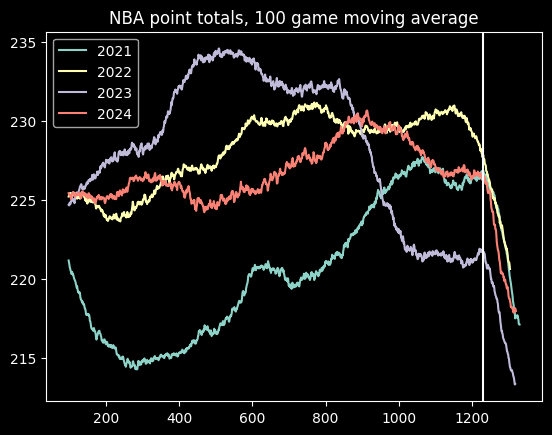

In [ ]:
plt.plot(to_plot, label="2021")
plt.plot(to_plot2, label="2022")
plt.plot(to_plot3, label="2023")
plt.plot(to_plot4, label="2024")
plt.title("NBA point totals, 100 game moving average")
plt.axvline(1230, color='white')
plt.legend()

how did the over do by year?

In [ ]:
year_2021.total_over_won.value_counts()

total_over_won
False    668
True     662
Name: count, dtype: int64

In [ ]:
year_2022.total_over_won.value_counts()

total_over_won
True     665
False    639
Name: count, dtype: int64

In [ ]:
year_2023.total_over_won.value_counts()

total_over_won
False    669
True     649
Name: count, dtype: int64

In [ ]:
year_2024.total_over_won.value_counts()

total_over_won
True     696
False    624
Name: count, dtype: int64

### pigeonhole principle worked example

In [ ]:
(.51 * .96) + (.55 *.04)

0.5115999999999999

In [ ]:
.51 * 1230

627.3

In [ ]:
1230 - 627

603

In [ ]:
.96 * 1230

1180.8

In [ ]:
1230 -1181

49

In [ ]:
627/1181

0.5309060118543607

In [ ]:
627 + 49

676

In [ ]:
(627 + 49) / 1230

0.5495934959349593

In [ ]:
((100 * .549) - (110 * (1-.549))) / 110

0.04809090909090921

maximum underdog bet taken (TODO)